# Sentiment Analysis for Mental Health
## Exploratory Data Analysis, Bag-of-Words Baseline Model, Bag-of-Embeddings
### Author(s): Edwin Figueroa & Victoria Do

#### ``Data``

https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/data


---

# Step 1: Import Libraries

In [1]:
# General Purpose Libraries
import os
import re
import pickle
from collections import Counter
import shutil

# Data Manipulation and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text Processing and NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.util import bigrams, ngrams
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Machine Learning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.utils.class_weight import compute_class_weight

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE

# Deep Learning with TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    TextVectorization, Embedding, Dense, GlobalAveragePooling1D,
    Dropout, Flatten, LSTM, GRU
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Hugging Face Transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# Hyperparameter Tuning with Keras Tuner
!pip install keras-tuner --upgrade
import keras_tuner as kt
from keras_tuner import HyperParameters

# Google Drive Integration (for Colab)
from google.colab import drive
drive.mount('/content/drive')

# Verify NLTK Paths
print("Updated NLTK paths:", nltk.data.path)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00
Mounted at /content/drive
Updated NLTK paths: ['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


---
# Step 2: Data Loading

In [2]:
# edit the path to the project folder as needed
folder_path = '/content/drive/My Drive/Data Science/Courses/DATASCI 207 Introduction to Machine Learning/Final Project/datasci207-final-project/'

In [3]:
# get file_path
file_name = 'data/raw_data.csv'
file_path = f"{folder_path}/{file_name}"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# name columns
df.rename(columns={'Unnamed: 0': 'unique_id'}, inplace = True)

# Display the DataFrame
df.head()

,unique_id,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


---
# Step 3: Exploratory Data Analysis (Before Text Preprocessing)

### Explore Missing Data

Data Shape: Rows = 53043 , Columns = 3

Missing Values by Column:
unique_id      0
statement    362
status         0
dtype: int64

Distribution of 'status' for missing 'statement':
status
Personality disorder    124
Bipolar                 100
Stress                   82
Anxiety                  47
Normal                    8
Suicidal                  1
Name: count, dtype: int64


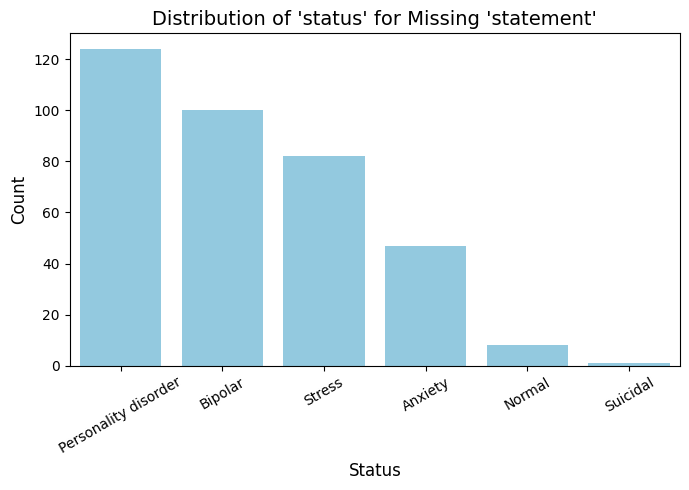

In [4]:
# filter rows where statement column is missing
missing_statement_data = df[df['statement'].isnull()]

# calculate the distribution of status for missing statement rows
status_distribution = missing_statement_data['status'].value_counts()

# print data shape and distribution of status
print("Data Shape: Rows =", df.shape[0], ", Columns =", df.shape[1])
print("\nMissing Values by Column:")
print(df.isnull().sum())
print("\nDistribution of 'status' for missing 'statement':")
print(status_distribution)

# plot the distribution
plt.figure(figsize=(7, 5))
sns.barplot(
    x = status_distribution.index,
    y=status_distribution.values,
    color='skyblue'
)

# labels
plt.title("Distribution of 'status' for Missing 'statement'", fontsize=14)
plt.xlabel("Status", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()

# display the plot
plt.show()

### Evaluate the Balance of Status (Class Balance)

Data Shape: Rows = 51795 , Columns = 9

Overall Distribution of 'status':
status
Normal                  15511
Depression              15372
Suicidal                10644
Anxiety                  3829
Bipolar                  2777
Stress                   2585
Personality disorder     1077
Name: count, dtype: int64

Percentages of 'status':
status
Normal                  30.0
Depression              30.0
Suicidal                21.0
Anxiety                  7.0
Bipolar                  5.0
Stress                   5.0
Personality disorder     2.0
Name: count, dtype: float64


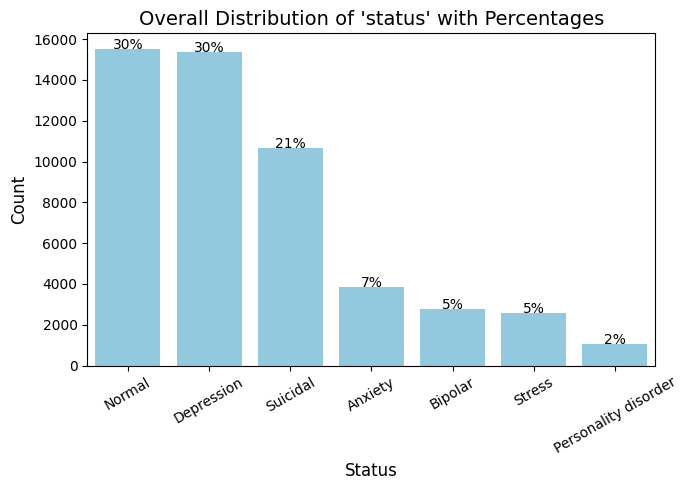

In [17]:
# remove missing statements
df = df[df['statement'].notnull()]

# Add statement length field
df['statement_len'] = df['statement'].apply(lambda x: len(x.split(' ')))

# Remove statements with less than 2 words
df = df[df['statement_len'] > 2].reset_index(drop = True)

# calculate the overall distribution of status and percentages
status_distribution_overall = df['status'].value_counts()
status_percentages = (status_distribution_overall / df.shape[0]) * 100

# print data shape and overall status distribution with percentages
print("Data Shape: Rows =", df.shape[0], ", Columns =", df.shape[1])
print("\nOverall Distribution of 'status':")
print(status_distribution_overall)
print("\nPercentages of 'status':")
print(status_percentages.round())

# plot the overall status distribution with percentages
plt.figure(figsize=(7, 5))
sns.barplot(x=status_distribution_overall.index, y=status_distribution_overall.values, color='skyblue')

# titles and labels
plt.title("Overall Distribution of 'status' with Percentages", fontsize=14)
plt.xlabel("Status", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=30)

# put the percentages on the bars
for index, value in enumerate(status_distribution_overall.values):
    percentage = f"{round(status_percentages.values[index]):.0f}%"
    plt.text(index, value + 5, percentage, ha='center', fontsize=10)

plt.tight_layout()

# output
plt.show()

---
# Step 4: Perform Text Preprocessing

In [6]:
# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# additional domain-specific stopwords
domain_stopwords = set([
    "mental",
    "health",
    "condition",
    "like", "feel",
    "know",
    "year",
    "old",
    "even",
    "though",
    "ive"
])

# Define stopwords (including custom domain-specific stopwords)
all_stopwords = set(stopwords.words('english'))

# Prep statements for models
def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    # Regex
    text = re.sub(
        r'http[s]?://\S+|www\.\S+|\S+\.(com|org|edu|gov|net|io|co)\S*|'
        r'\[.*?\]|<.*?>+|@\w+|\n|\w*\d\w*|[^a-zA-Z\s]',
        ' ',
        text
    )

    # Lowercase and remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip().lower()

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens if len(word) > 2 and word not in all_stopwords and word not in domain_stopwords]

    return tokens

In [7]:
# get processed_file_path
processed_file_name = 'data/processed_data_VD.pkl'
processed_file_path = f"{folder_path}/{processed_file_name}"

# Check if the processed file exists
if os.path.exists(processed_file_path):
    # Load the processed data
    df = pd.read_pickle(processed_file_path)
    print("Processed data loaded from file.")
else:
    # Perform preprocessing
    df['processed_text'] = df['statement'].dropna().apply(preprocess_text)

    # Save the processed data to a file
    df.to_pickle(processed_file_path)
    print("Processed data saved to file.")

df.head()

Processed data loaded from file.


,unique_id,statement,status,statement_len,processed_text
0,0,oh my gosh,Anxiety,3,[gosh]
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,"[trouble, sleeping, confused, mind, restless, ..."
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,"[wrong, back, dear, forward, doubt, stay, rest..."
3,3,I've shifted my focus to something else but I'...,Anxiety,11,"[shifted, focus, something, else, still, worried]"
4,4,"I'm restless and restless, it's been a month n...",Anxiety,14,"[restless, restless, month, boy, mean]"


---
# Step 5: Exploratory Data Analysis (After Text Preprocessing)

### Most Useful Common Words per Category

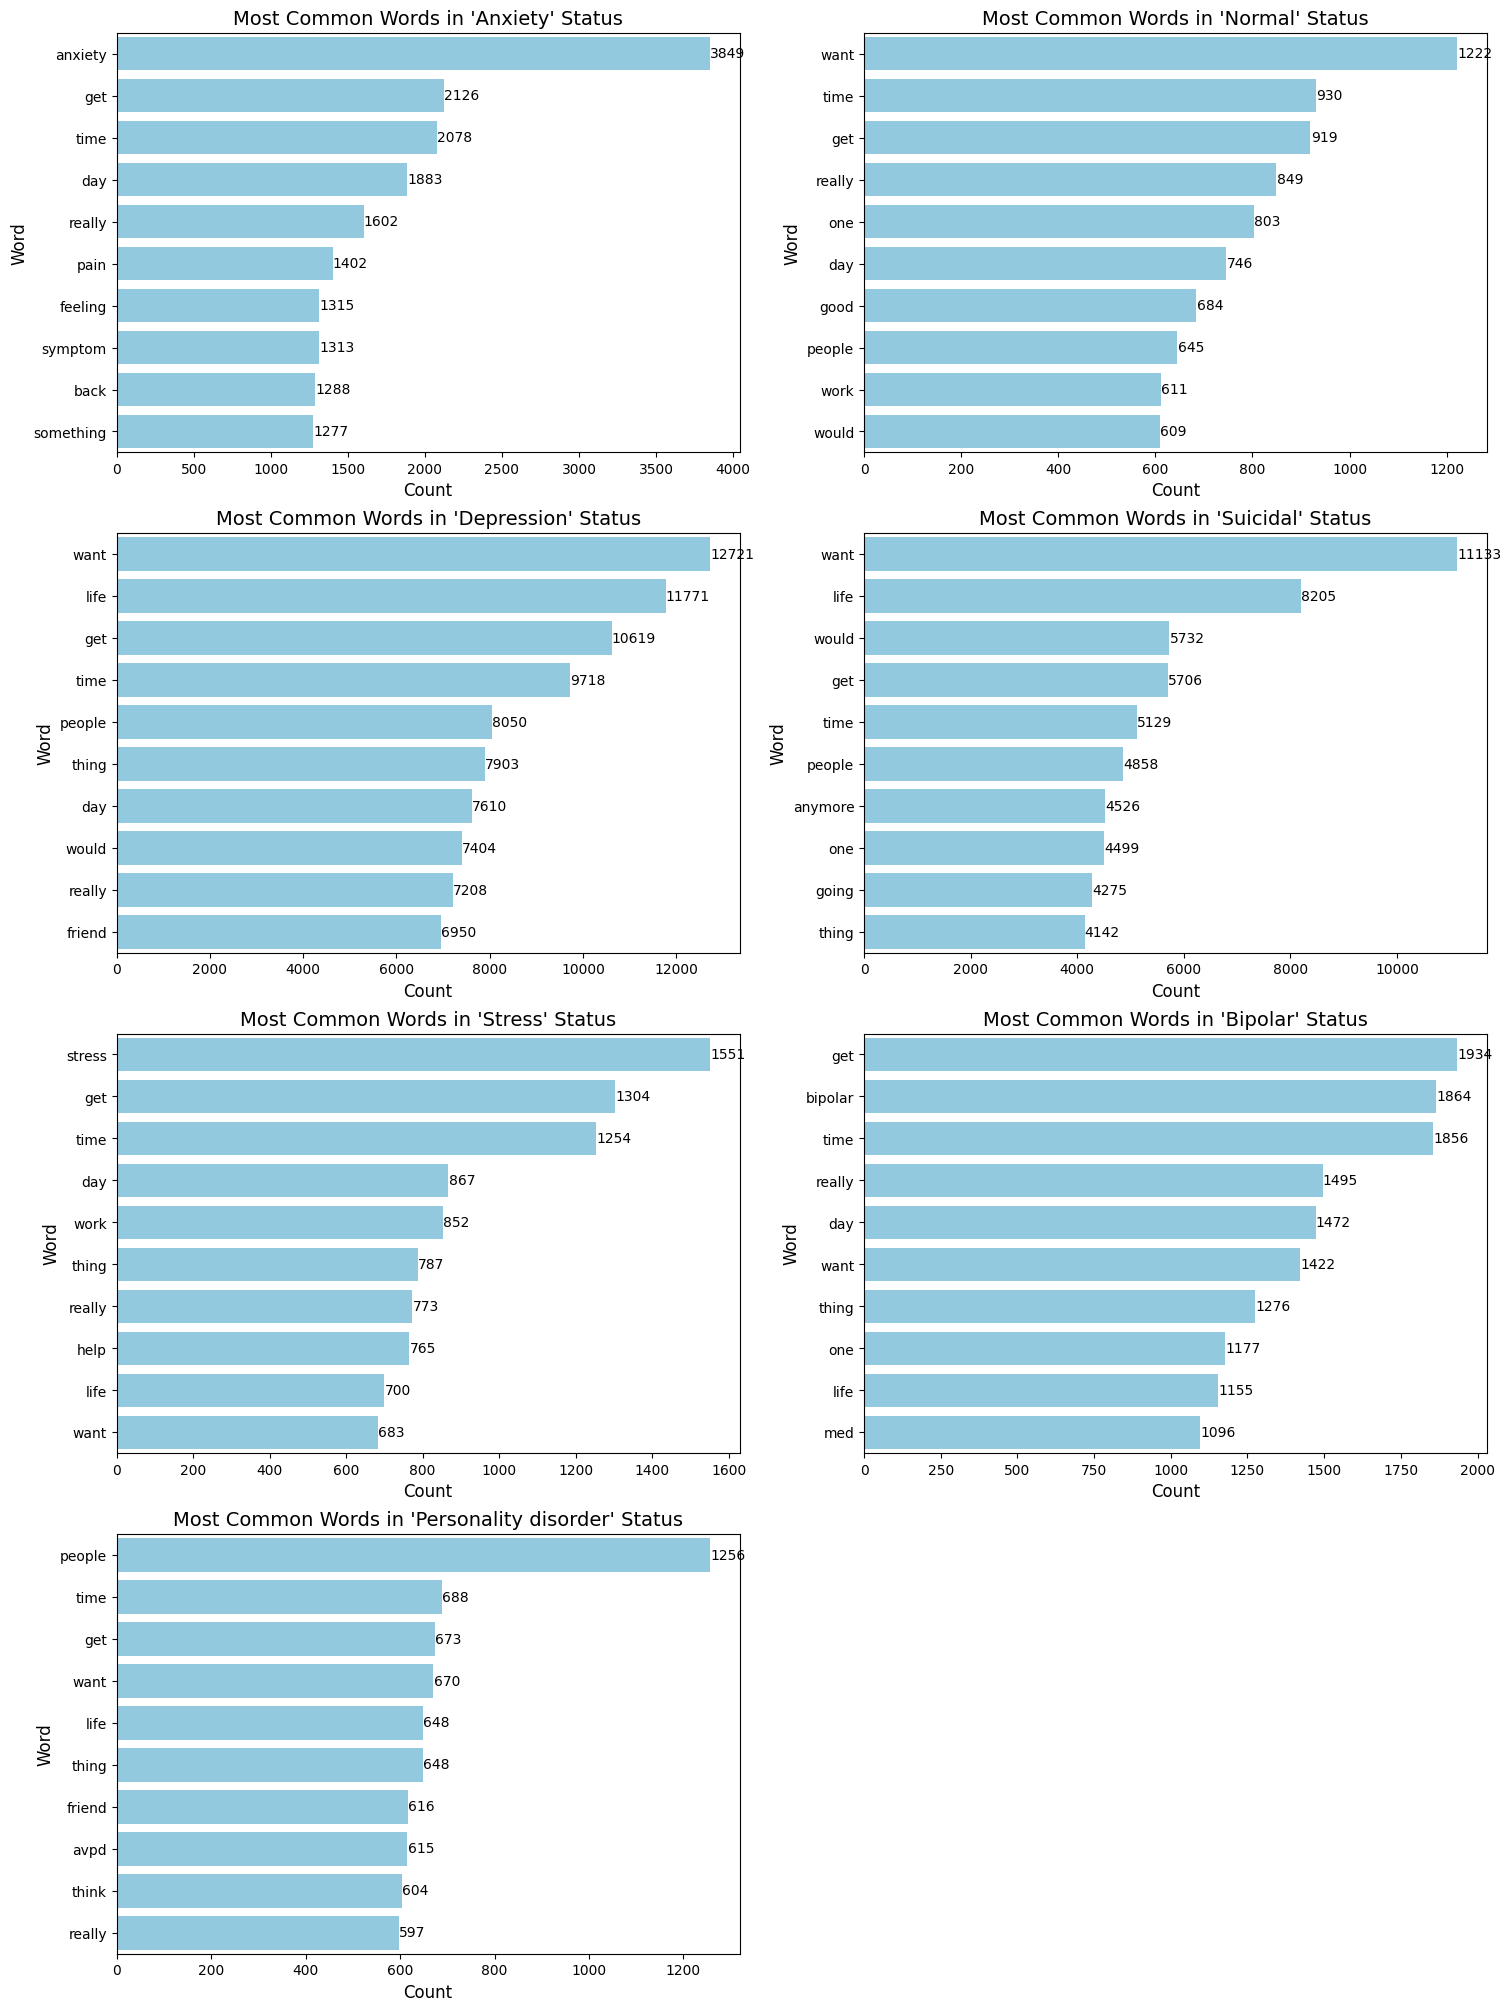

In [8]:
# Collect unique hits on status
status_categories = df['status'].unique()

# Function to get most common words for a given status
def get_common_words(df, status, n=10):
    # Filter for specific status and flatten preprocessed words
    filtered_text = df[df['status'] == status]['processed_text']
    words = [word for text in filtered_text for word in text]
    # Get most common words
    return Counter(words).most_common(n)

# Prepare for multiple plots because each status will have its own plot
num_status = len(status_categories)
cols = 2
rows = (num_status + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)

# Flatten axes to make iteration simpler
axes = axes.flatten()

# Iterate over status categories
for idx, status in enumerate(status_categories):
    # Get most common words for the current status
    most_common_words = get_common_words(df, status, n=10)
    most_common_df = pd.DataFrame(most_common_words, columns=['Word', 'Count'])

    sns.barplot(data=most_common_df, x='Count', y='Word', color='skyblue', ax=axes[idx])
    axes[idx].set_title(f"Most Common Words in '{status}' Status", fontsize=14)
    axes[idx].set_xlabel("Count", fontsize=12)
    axes[idx].set_ylabel("Word", fontsize=12)

    for bar, count in zip(axes[idx].patches, most_common_df['Count']):
        axes[idx].text(
            bar.get_width() + 1,
            bar.get_y() + bar.get_height() / 2,
            f"{count}",
            va='center', fontsize=10
        )

# Remove empty subplots if any
for idx in range(len(status_categories), len(axes)):
    fig.delaxes(axes[idx])

plt.show()

### Most Common Bi-Gram per Category

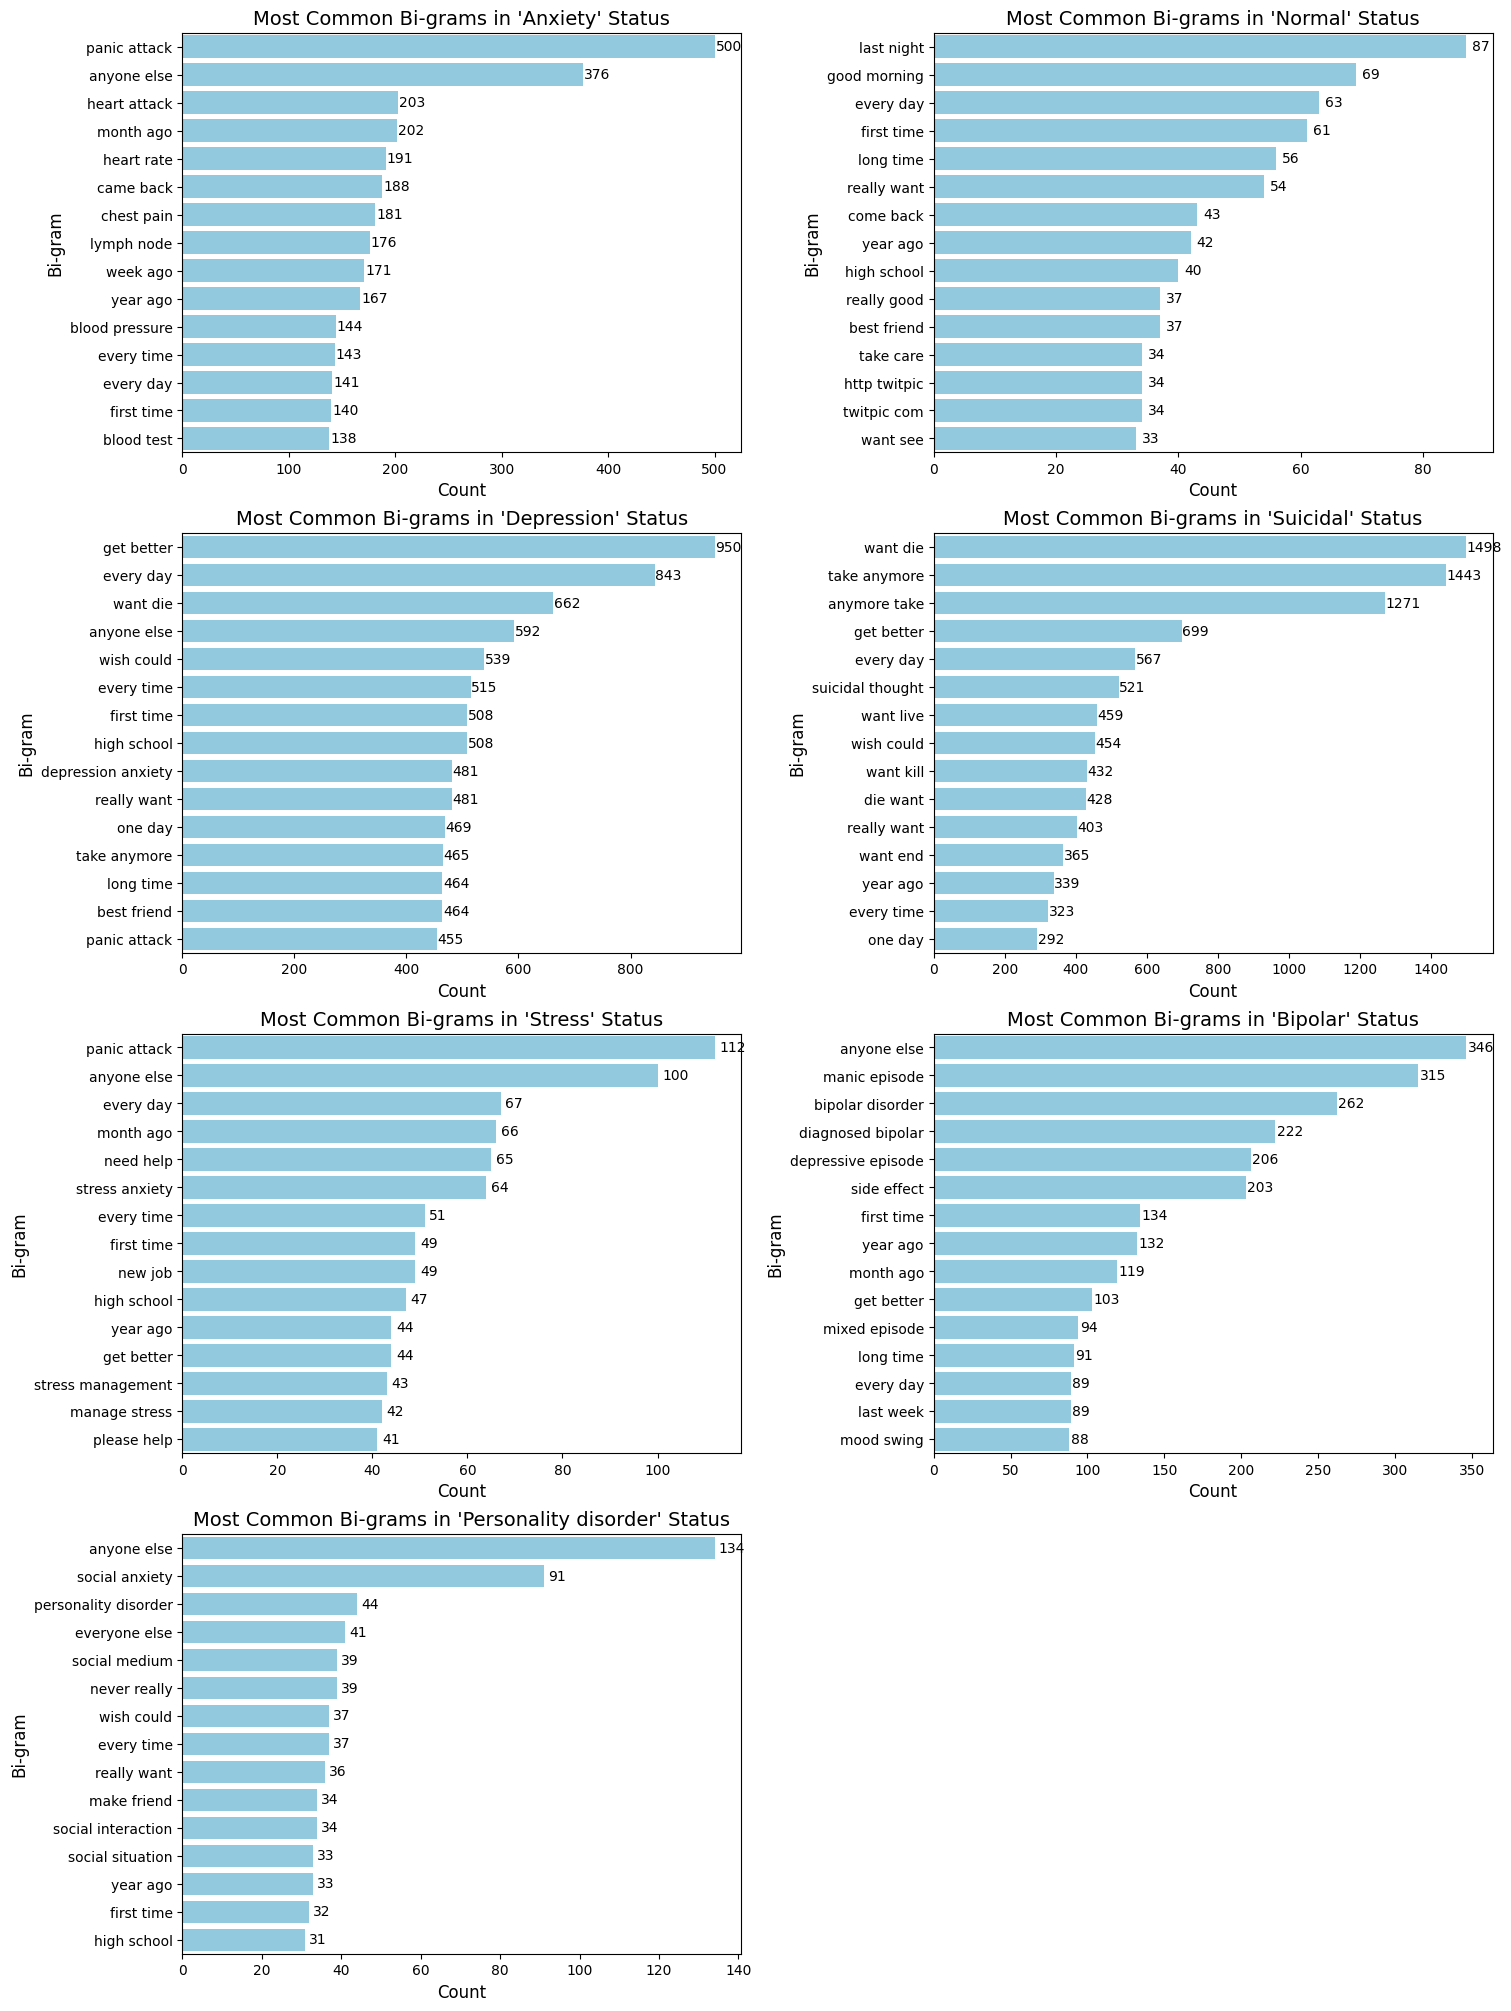

In [9]:
# Function to get most common bi-grams for a given status
def get_common_bigrams(df, status, n=15):
    # Filter for specific status and extract tokens
    filtered_text = df[df['status'] == status]['processed_text']
    # Flatten tokens and generate bi-grams
    bigram_list = [bigram for text in filtered_text for bigram in bigrams(text)]
    # Get most common bi-grams
    return Counter(bigram_list).most_common(n)

status_categories = df['status'].unique()
num_status = len(status_categories)
cols = 2
rows = (num_status + 1) // cols  # Calculate number of rows needed
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)

axes = axes.flatten()

# Iterate over status categories
for idx, status in enumerate(status_categories):
    # Get most common bi-grams for the current status
    most_common_bigrams = get_common_bigrams(df, status, n=15)
    # Convert bi-grams to a readable format (e.g., "word1 word2")
    most_common_df = pd.DataFrame(
        [(f"{w1} {w2}", count) for (w1, w2), count in most_common_bigrams],
        columns=['Bi-gram', 'Count']
    )

    # Plot the most common bi-grams
    sns.barplot(data=most_common_df, x='Count', y='Bi-gram', color='skyblue', ax=axes[idx])
    axes[idx].set_title(f"Most Common Bi-grams in '{status}' Status", fontsize=14)
    axes[idx].set_xlabel("Count", fontsize=12)
    axes[idx].set_ylabel("Bi-gram", fontsize=12)

    # Add the count on the bars
    for bar, count in zip(axes[idx].patches, most_common_df['Count']):
        axes[idx].text(
            bar.get_width() + 1,
            bar.get_y() + bar.get_height() / 2,
            f"{count}",
            va='center', fontsize=10
        )
for idx in range(len(status_categories), len(axes)):
    fig.delaxes(axes[idx])

plt.show()

### Most Common N-Gram per Category

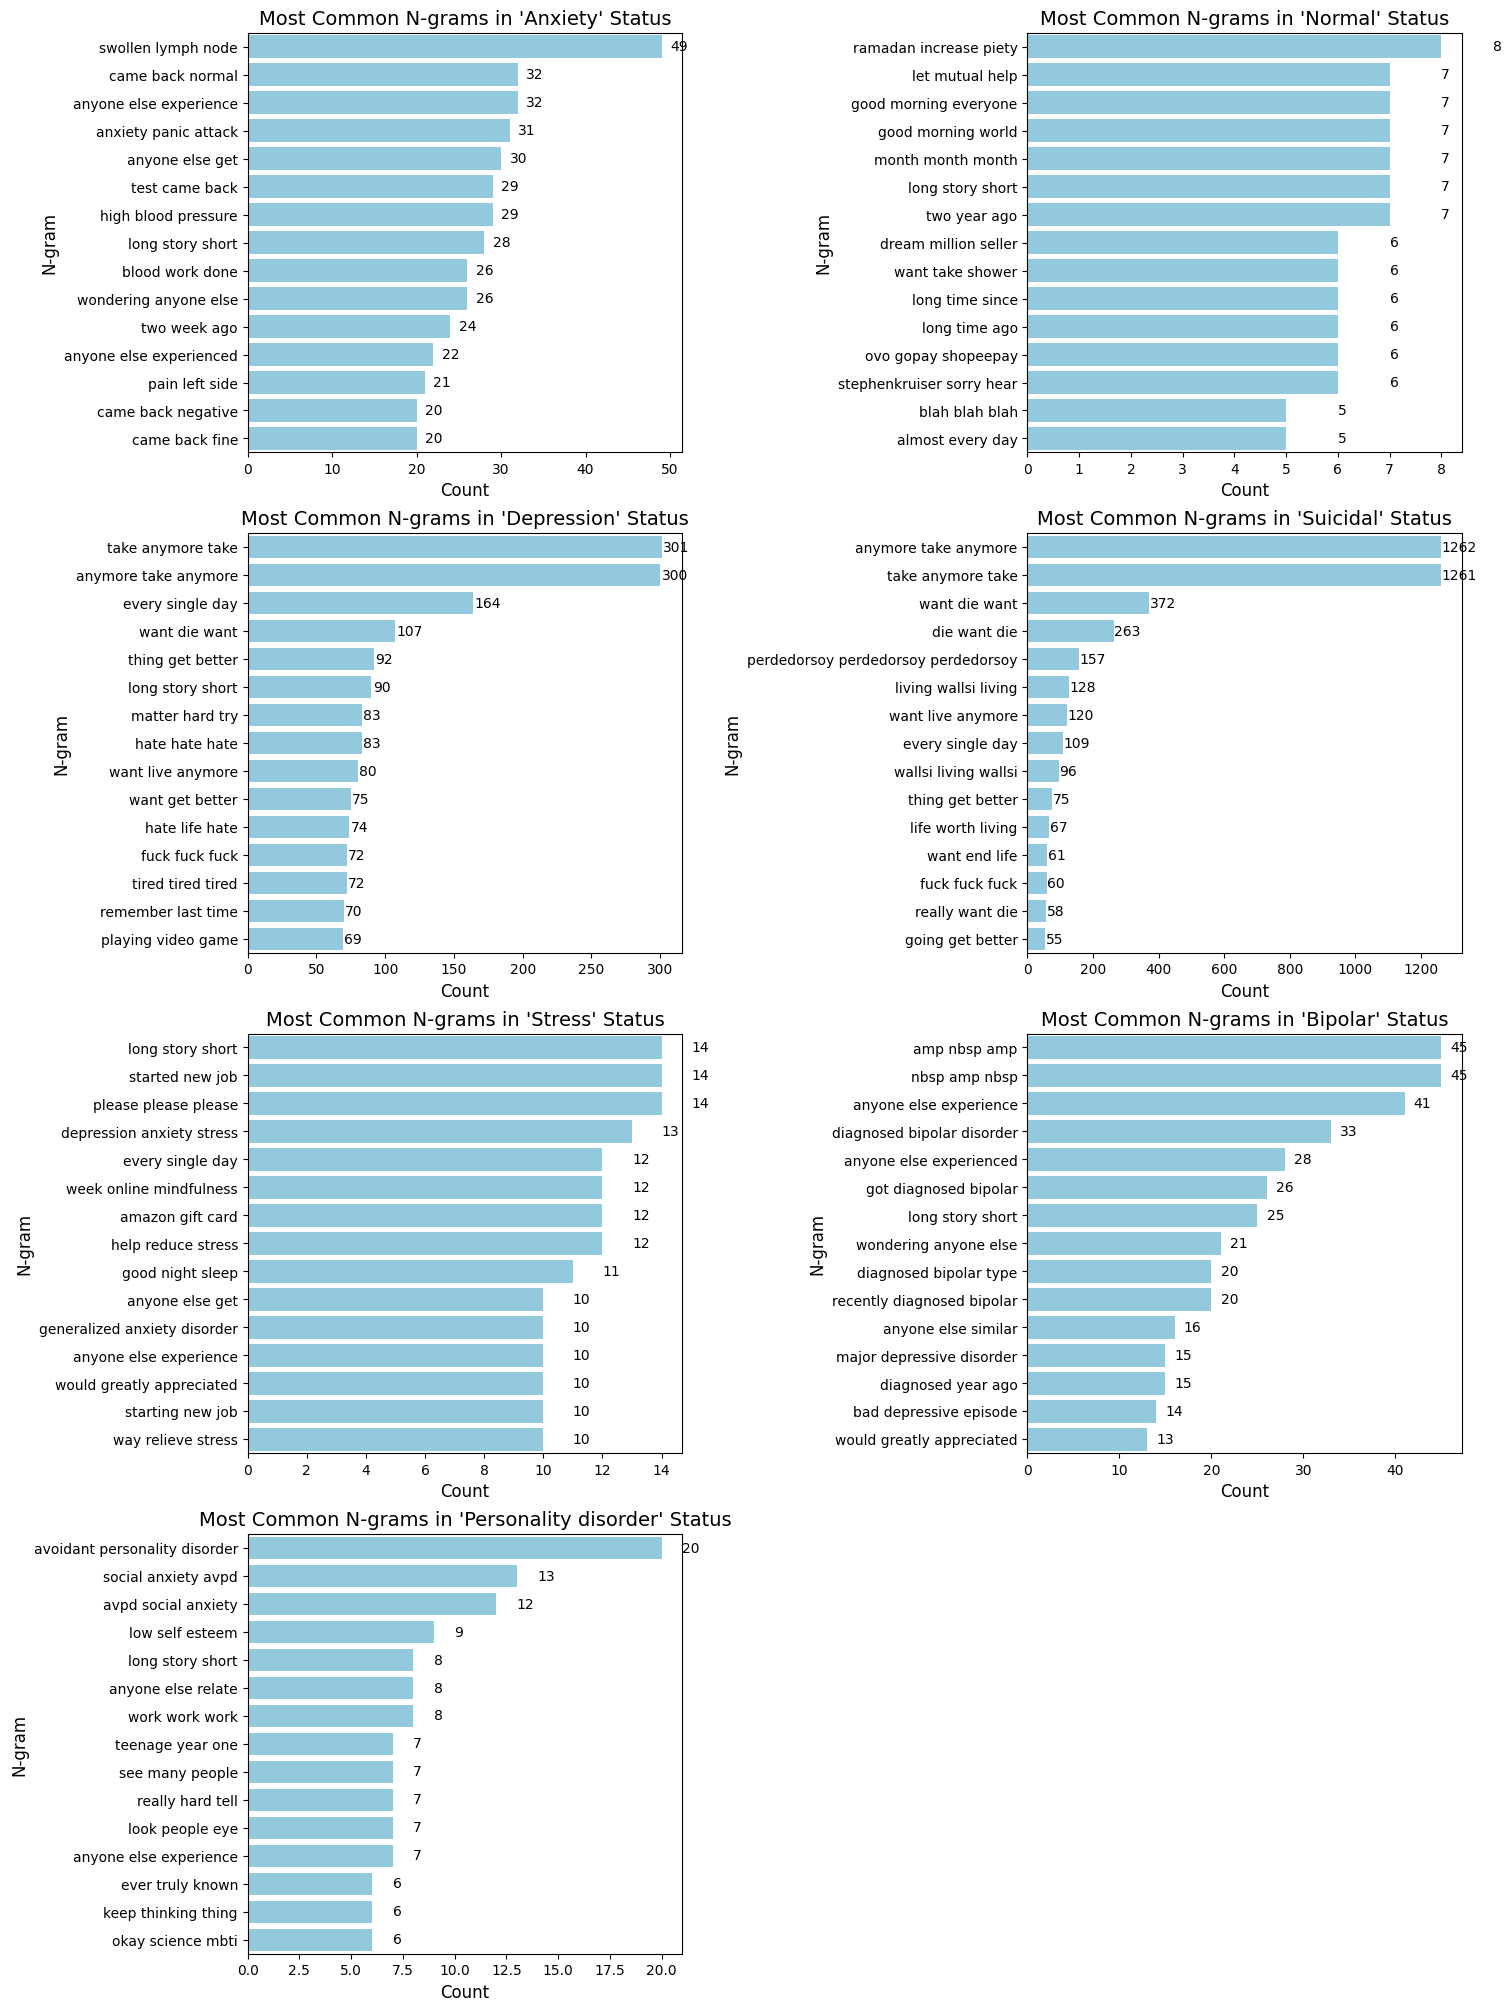

In [10]:
# Function to get most common N-grams for a given status
def get_common_ngrams(df, status, n=15):
    # Filter for specific status and extract tokens
    filtered_text = df[df['status'] == status]['processed_text']
    # Flatten tokens and filter out unwanted tokens
    cleaned_text = [
        [token for token in text if not re.match(r'http|www|com|org|edu|gov|net|io|co', token)]
        for text in filtered_text
    ]

    # Flatten tokens and generate N-grams
    ngram_list = [ngram for text in cleaned_text for ngram in ngrams(text, 3)]
    # Get most common N-grams
    return Counter(ngram_list).most_common(n)


status_categories = df['status'].unique()
num_status = len(status_categories)
cols = 2
rows = (num_status + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)


axes = axes.flatten()

# Iterate over status categories
for idx, status in enumerate(status_categories):
    # Get most common N-grams for the current status
    most_common_ngrams = get_common_ngrams(df, status, n=15)
    # Convert N-grams to a readable format (e.g., "word1 word2 word3")
    most_common_df = pd.DataFrame(
        [(f"{w1} {w2} {w3}", count) for (w1, w2, w3), count in most_common_ngrams],
        columns=['N-gram', 'Count']
    )

    # Plot the most common N-grams
    sns.barplot(data=most_common_df, x='Count', y='N-gram', color='skyblue', ax=axes[idx])
    axes[idx].set_title(f"Most Common N-grams in '{status}' Status", fontsize=14)
    axes[idx].set_xlabel("Count", fontsize=12)
    axes[idx].set_ylabel("N-gram", fontsize=12)

    for bar, count in zip(axes[idx].patches, most_common_df['Count']):
        axes[idx].text(
            bar.get_width() + 1,
            bar.get_y() + bar.get_height() / 2,
            f"{count}",
            va='center', fontsize=10
        )

for idx in range(len(status_categories), len(axes)):
    fig.delaxes(axes[idx])

plt.show()

---
# Step 6: Grouping Status Into New Class Labels

## Grouping with 4 Classes

In [11]:
# Define the mapping for status groups
status_mapping_4 = {
    "Normal": "Normal",
    "Depression": "Depression",
    "Suicidal": "Suicidal",
    # Any status not explicitly listed will default to "Class 4: Other"
}

# Apply the mapping to the status column
df['grouped_status_4'] = df['status'].map(status_mapping_4).fillna("Other")

# Encode new groups
l_encoder_4 = LabelEncoder()
l_encoder_4.fit(df['grouped_status_4'])

df['status_encoded_4'] = l_encoder_4.transform(df['grouped_status_4'])
df.head()

,unique_id,statement,status,statement_len,processed_text,grouped_status_4,status_encoded_4
0,0,oh my gosh,Anxiety,3,[gosh],Other,2
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,"[trouble, sleeping, confused, mind, restless, ...",Other,2
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,"[wrong, back, dear, forward, doubt, stay, rest...",Other,2
3,3,I've shifted my focus to something else but I'...,Anxiety,11,"[shifted, focus, something, else, still, worried]",Other,2
4,4,"I'm restless and restless, it's been a month n...",Anxiety,14,"[restless, restless, month, boy, mean]",Other,2


### Distribution for New Classes

Data Shape: Rows = 51795 , Columns = 9

Overall Distribution of Classes (4 Groups):
grouped_status_4
Normal        15511
Depression    15372
Suicidal      10644
Other         10268
Name: count, dtype: int64

Percentages of Classes (4 Groups):
grouped_status_4
Normal        30.0
Depression    30.0
Suicidal      21.0
Other         20.0
Name: count, dtype: float64




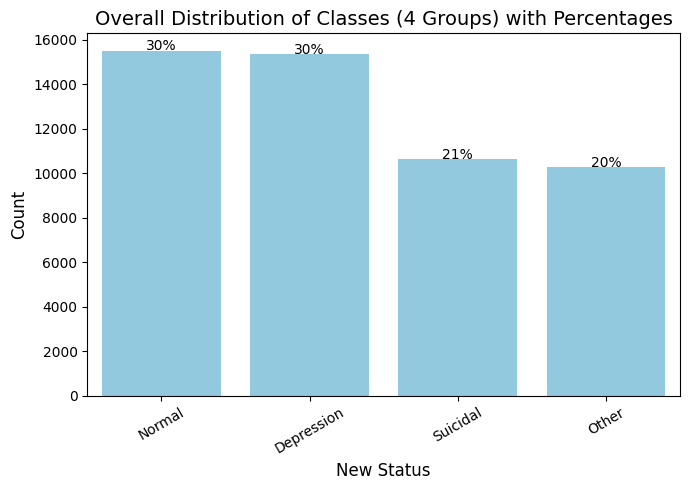

In [15]:
# calculate the overall distribution of status and percentages
status_distribution_overall = df['grouped_status_4'].value_counts()
status_percentages = (status_distribution_overall / df.shape[0]) * 100

# print data shape and overall status distribution with percentages
print("Data Shape: Rows =", df.shape[0], ", Columns =", df.shape[1])
print("\nOverall Distribution of Classes (4 Groups):")
print(status_distribution_overall)
print("\nPercentages of Classes (4 Groups):")
print(status_percentages.round())
print("\n")

# plot the overall status distribution with percentages
plt.figure(figsize=(7, 5))
sns.barplot(x=status_distribution_overall.index, y=status_distribution_overall.values, color='skyblue')

# titles and labels
plt.title("Overall Distribution of Classes (4 Groups) with Percentages", fontsize=14)
plt.xlabel("New Status", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=30)

# put the percentages on the bars
for index, value in enumerate(status_distribution_overall.values):
    percentage = f"{round(status_percentages.values[index]):.0f}%"
    plt.text(index, value + 5, percentage, ha='center', fontsize=10)

plt.tight_layout()

# output
plt.show()

## Grouping with 3 Classes

In [13]:
# Define the mapping for status groups
status_mapping_3 = {
    "Normal": "Normal",
    "Depression": "Depression",
    "Suicidal": "Depression",
    # Any status not explicitly listed will default to "Class 3: Other"
}

# Apply the mapping to the status column
df['grouped_status_3'] = df['status'].map(status_mapping_3).fillna("Other")

# Encode new groups
l_encoder_3 = LabelEncoder()
l_encoder_3.fit(df['grouped_status_3'])

df['status_encoded_3'] = l_encoder_3.transform(df['grouped_status_3'])
df.head()

,unique_id,statement,status,statement_len,processed_text,grouped_status_4,status_encoded_4,grouped_status_3,status_encoded_3
0,0,oh my gosh,Anxiety,3,[gosh],Other,2,Other,2
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,"[trouble, sleeping, confused, mind, restless, ...",Other,2,Other,2
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,"[wrong, back, dear, forward, doubt, stay, rest...",Other,2,Other,2
3,3,I've shifted my focus to something else but I'...,Anxiety,11,"[shifted, focus, something, else, still, worried]",Other,2,Other,2
4,4,"I'm restless and restless, it's been a month n...",Anxiety,14,"[restless, restless, month, boy, mean]",Other,2,Other,2


Data Shape: Rows = 51795 , Columns = 9

Overall Distribution of Classes (3 Groups):
grouped_status_3
Depression    26016
Normal        15511
Other         10268
Name: count, dtype: int64

Percentages of Classes (3 Groups):
grouped_status_3
Depression    50.0
Normal        30.0
Other         20.0
Name: count, dtype: float64




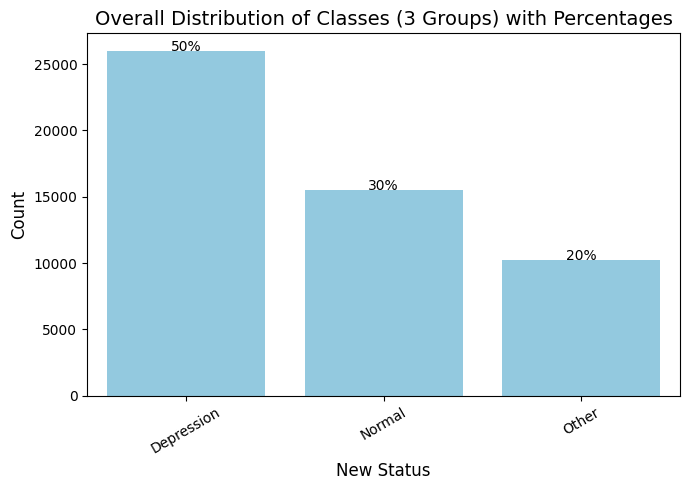

In [16]:
# calculate the overall distribution of status and percentages
status_distribution_overall = df['grouped_status_3'].value_counts()
status_percentages = (status_distribution_overall / df.shape[0]) * 100

# print data shape and overall status distribution with percentages
print("Data Shape: Rows =", df.shape[0], ", Columns =", df.shape[1])
print("\nOverall Distribution of Classes (3 Groups):")
print(status_distribution_overall)
print("\nPercentages of Classes (3 Groups):")
print(status_percentages.round())
print("\n")

# plot the overall status distribution with percentages
plt.figure(figsize=(7, 5))
sns.barplot(x=status_distribution_overall.index, y=status_distribution_overall.values, color='skyblue')

# titles and labels
plt.title("Overall Distribution of Classes (3 Groups) with Percentages", fontsize=14)
plt.xlabel("New Status", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=30)

# put the percentages on the bars
for index, value in enumerate(status_distribution_overall.values):
    percentage = f"{round(status_percentages.values[index]):.0f}%"
    plt.text(index, value + 5, percentage, ha='center', fontsize=10)

plt.tight_layout()

# output
plt.show()

---
# Step 7: Exploratory Data Analysis (After New Class Grouping)

## EDA for 4 Class Grouping

### Most Common Bi-Grams per Class (4 Groups)

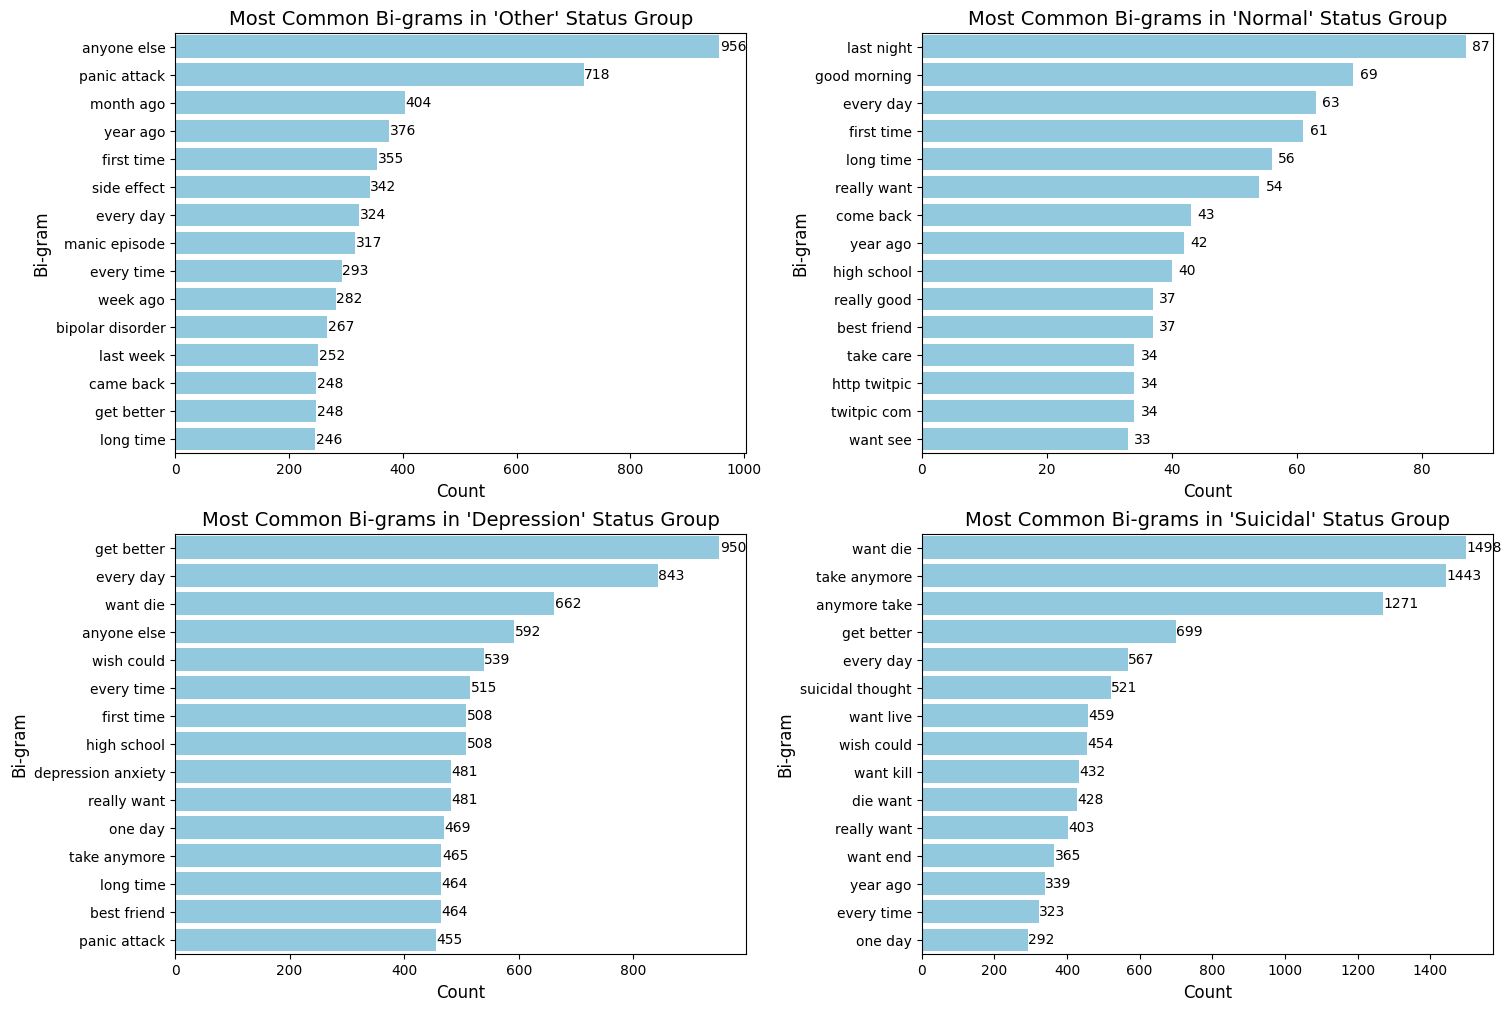

In [ ]:
# Function to get most common bi-grams for a given status group
def get_common_bigrams(df, status, n=15):
    # Filter for specific status and extract tokens
    filtered_text = df[df['grouped_status_4'] == status]['processed_text']
    # Flatten tokens and generate bi-grams
    bigram_list = [bigram for text in filtered_text for bigram in bigrams(text)]
    # Get most common bi-grams
    return Counter(bigram_list).most_common(n)

status_categories = df['grouped_status_4'].unique()
num_status = len(status_categories)
cols = 2
rows = (num_status + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)

axes = axes.flatten()

# Iterate over status categories
for idx, status in enumerate(status_categories):
    # Get most common bi-grams for the current status
    most_common_bigrams = get_common_bigrams(df, status, n=15)
    # Convert bi-grams to a readable format (e.g., "word1 word2")
    most_common_df = pd.DataFrame(
        [(f"{w1} {w2}", count) for (w1, w2), count in most_common_bigrams],
        columns=['Bi-gram', 'Count']
    )

    # Plot the most common bi-grams
    sns.barplot(data=most_common_df, x='Count', y='Bi-gram', color='skyblue', ax=axes[idx])
    axes[idx].set_title(f"Most Common Bi-grams in '{status}' Status Group", fontsize=14)
    axes[idx].set_xlabel("Count", fontsize=12)
    axes[idx].set_ylabel("Bi-gram", fontsize=12)

    # Add the count on the bars
    for bar, count in zip(axes[idx].patches, most_common_df['Count']):
        axes[idx].text(
            bar.get_width() + 1,
            bar.get_y() + bar.get_height() / 2,
            f"{count}",
            va='center', fontsize=10
        )
for idx in range(len(status_categories), len(axes)):
    fig.delaxes(axes[idx])

plt.show()

### Most Common N-Gram per Class (4 Groups)

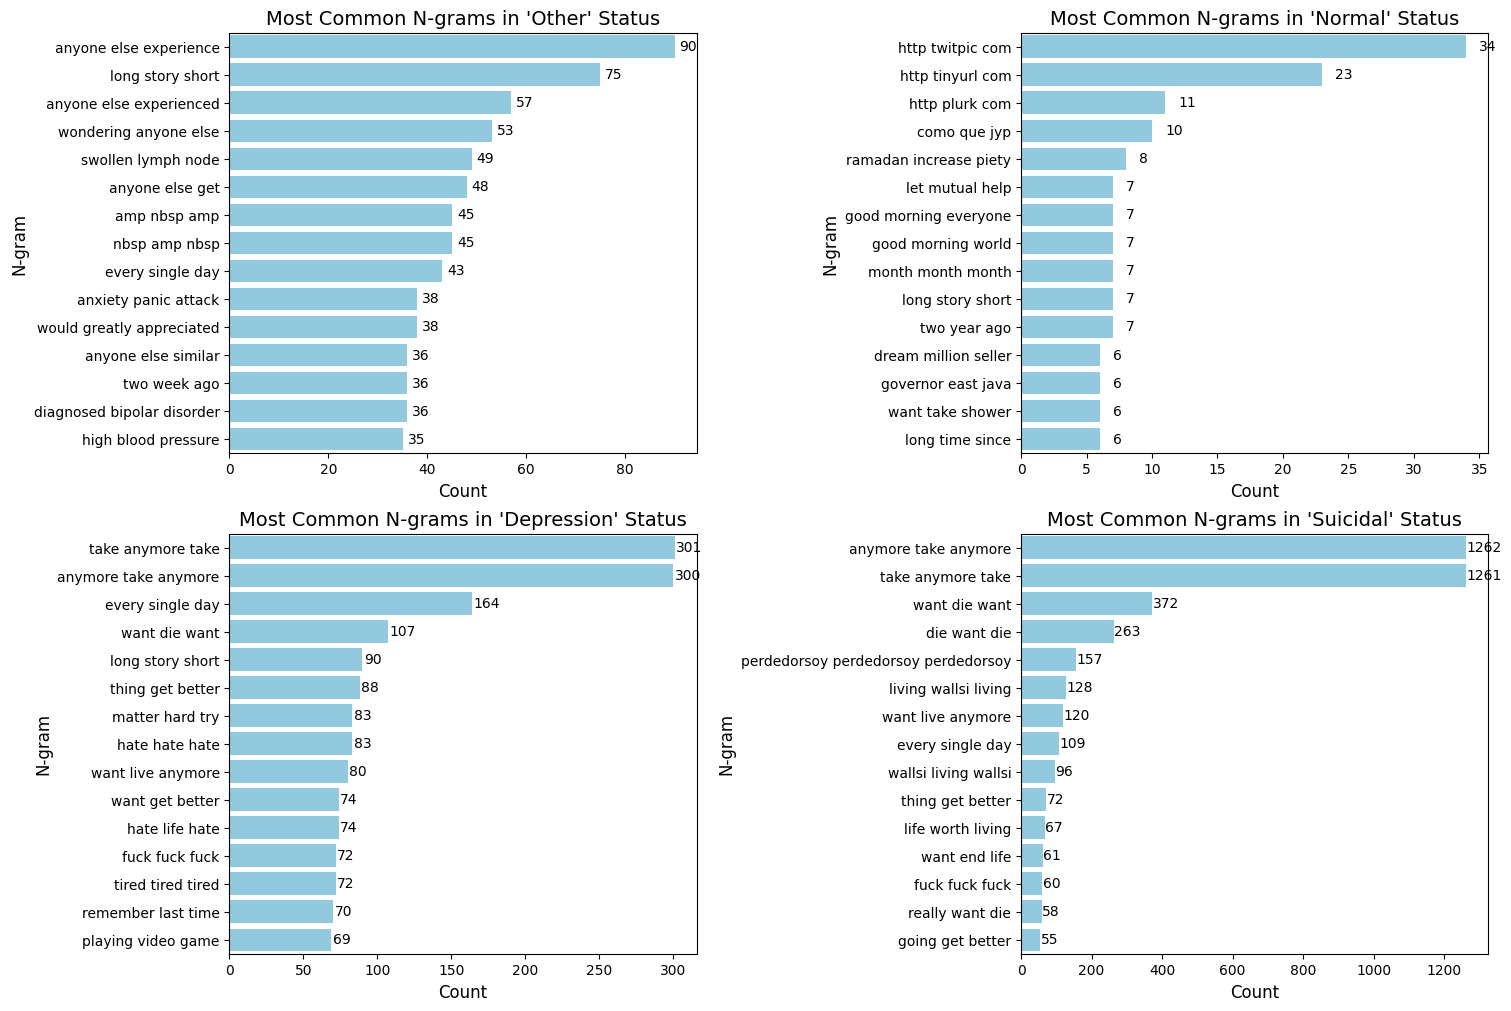

In [ ]:
# Helper function to remove duplicates while preserving token order

# Function to get most common N-grams for a given status
def get_common_ngrams(df, status, n=15):
    # Filter for specific status and extract tokens
    filtered_text = df[df['grouped_status_4'] == status]['processed_text']

    # Generate N-grams from cleaned, unique tokens
    ngram_list = [ngram for text in filtered_text for ngram in ngrams(text, 3)]

    # Get most common N-grams
    return Counter(ngram_list).most_common(n)


status_categories = df['grouped_status_4'].unique()
num_status = len(status_categories)
cols = 2
rows = (num_status + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)


axes = axes.flatten()

# Iterate over status categories
for idx, status in enumerate(status_categories):
    # Get most common N-grams for the current status
    most_common_ngrams = get_common_ngrams(df, status, n=15)
    # Convert N-grams to a readable format (e.g., "word1 word2 word3")
    most_common_df = pd.DataFrame(
        [(f"{w1} {w2} {w3}", count) for (w1, w2, w3), count in most_common_ngrams],
        columns=['N-gram', 'Count']
    )

    # Plot the most common N-grams
    sns.barplot(data=most_common_df, x='Count', y='N-gram', color='skyblue', ax=axes[idx])
    axes[idx].set_title(f"Most Common N-grams in '{status}' Status", fontsize=14)
    axes[idx].set_xlabel("Count", fontsize=12)
    axes[idx].set_ylabel("N-gram", fontsize=12)

    for bar, count in zip(axes[idx].patches, most_common_df['Count']):
        axes[idx].text(
            bar.get_width() + 1,
            bar.get_y() + bar.get_height() / 2,
            f"{count}",
            va='center', fontsize=10
        )

for idx in range(len(status_categories), len(axes)):
    fig.delaxes(axes[idx])

plt.show()

## EDA for 3 Class Grouping

### Most Common Bi-Grams per Class (3 Groups)

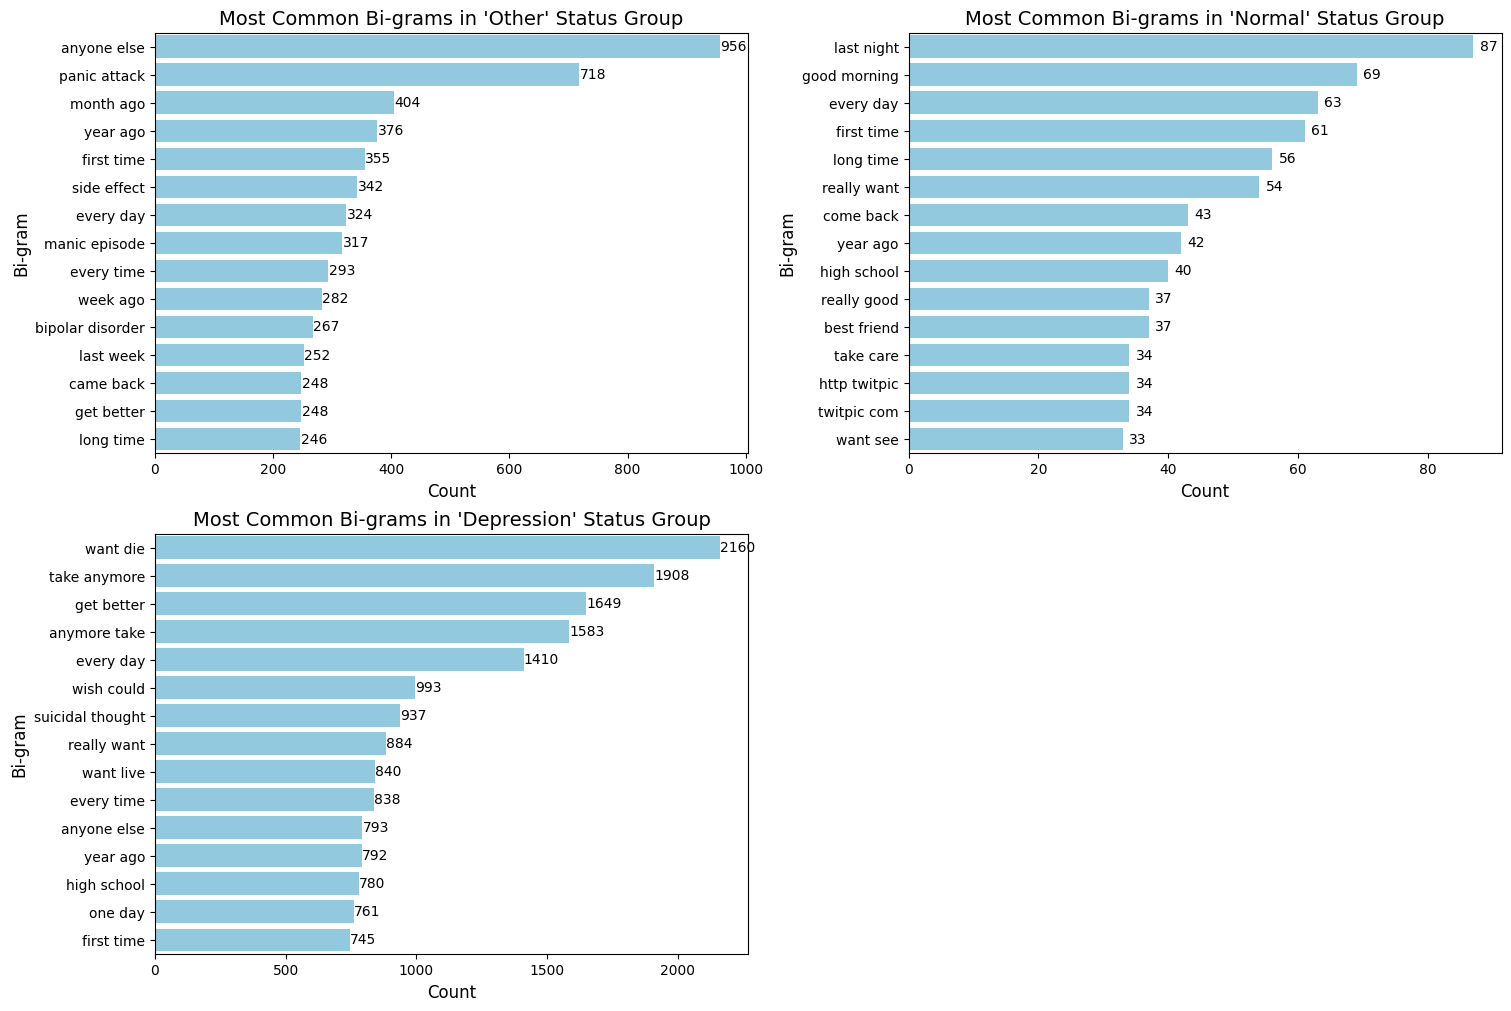

In [ ]:
# Function to get most common bi-grams for a given status group
def get_common_bigrams(df, status, n=15):
    # Filter for specific status and extract tokens
    filtered_text = df[df['grouped_status_3'] == status]['processed_text']
    # Flatten tokens and generate bi-grams
    bigram_list = [bigram for text in filtered_text for bigram in bigrams(text)]
    # Get most common bi-grams
    return Counter(bigram_list).most_common(n)

status_categories = df['grouped_status_3'].unique()
num_status = len(status_categories)
cols = 2
rows = (num_status + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)

axes = axes.flatten()

# Iterate over status categories
for idx, status in enumerate(status_categories):
    # Get most common bi-grams for the current status
    most_common_bigrams = get_common_bigrams(df, status, n=15)
    # Convert bi-grams to a readable format (e.g., "word1 word2")
    most_common_df = pd.DataFrame(
        [(f"{w1} {w2}", count) for (w1, w2), count in most_common_bigrams],
        columns=['Bi-gram', 'Count']
    )

    # Plot the most common bi-grams
    sns.barplot(data=most_common_df, x='Count', y='Bi-gram', color='skyblue', ax=axes[idx])
    axes[idx].set_title(f"Most Common Bi-grams in '{status}' Status Group", fontsize=14)
    axes[idx].set_xlabel("Count", fontsize=12)
    axes[idx].set_ylabel("Bi-gram", fontsize=12)

    # Add the count on the bars
    for bar, count in zip(axes[idx].patches, most_common_df['Count']):
        axes[idx].text(
            bar.get_width() + 1,
            bar.get_y() + bar.get_height() / 2,
            f"{count}",
            va='center', fontsize=10
        )
for idx in range(len(status_categories), len(axes)):
    fig.delaxes(axes[idx])

plt.show()

### Most Common N-Gram per Class (3 Groups)

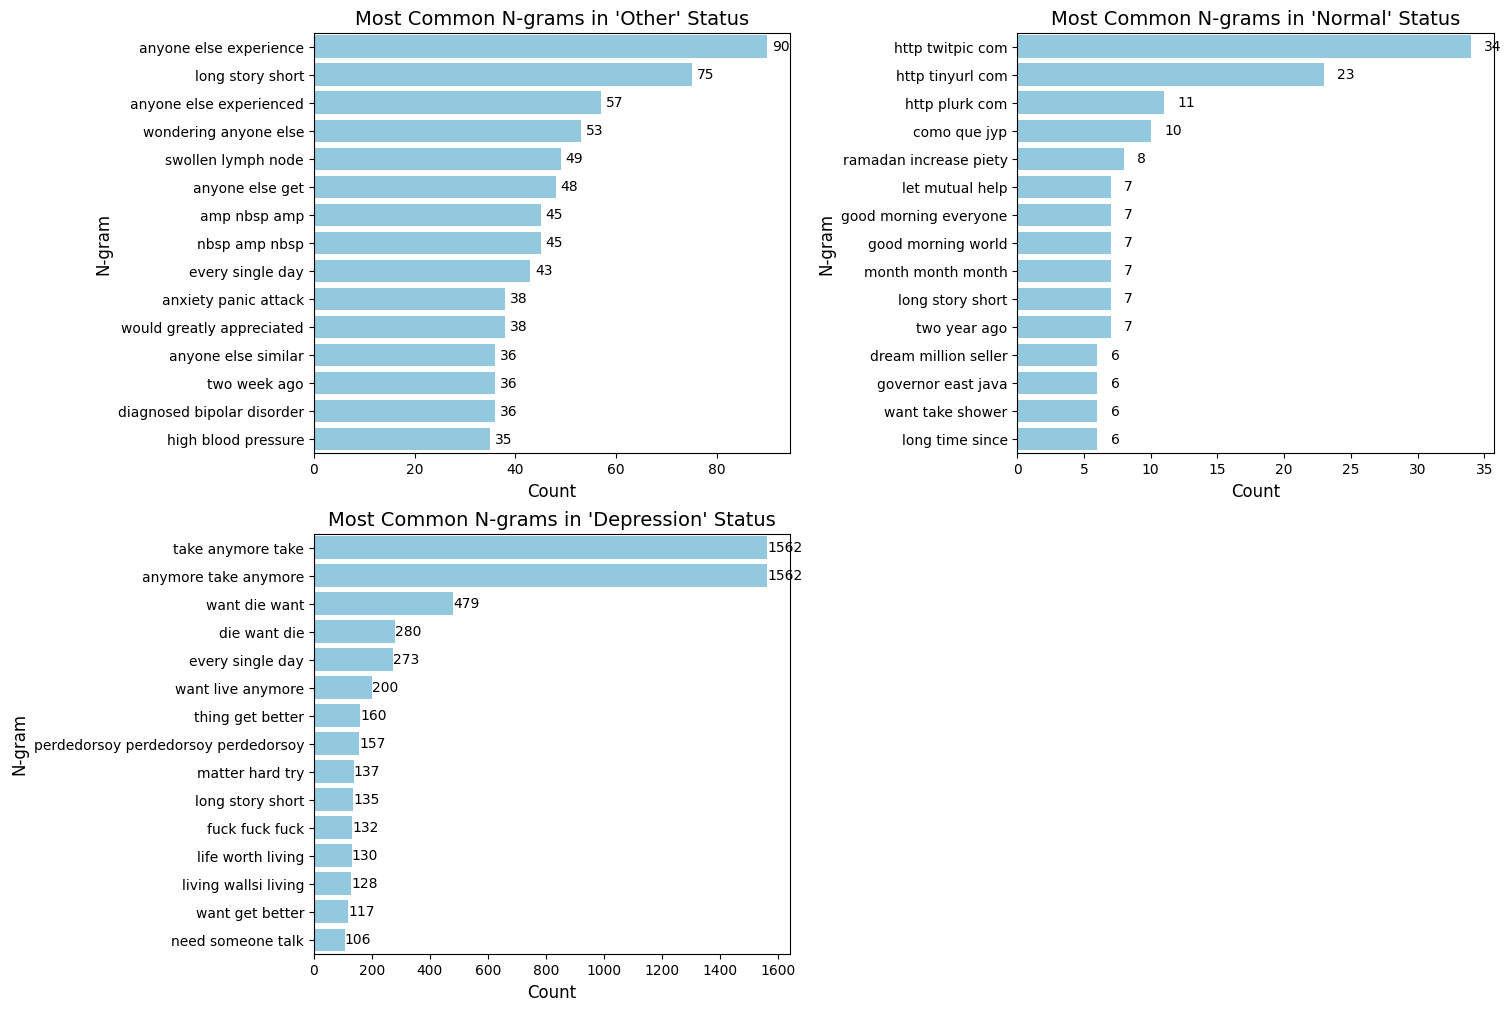

In [ ]:
# Helper function to remove duplicates while preserving token order

# Function to get most common N-grams for a given status
def get_common_ngrams(df, status, n=15):
    # Filter for specific status and extract tokens
    filtered_text = df[df['grouped_status_3'] == status]['processed_text']

    # Generate N-grams from cleaned, unique tokens
    ngram_list = [ngram for text in filtered_text for ngram in ngrams(text, 3)]

    # Get most common N-grams
    return Counter(ngram_list).most_common(n)


status_categories = df['grouped_status_3'].unique()
num_status = len(status_categories)
cols = 2
rows = (num_status + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)


axes = axes.flatten()

# Iterate over status categories
for idx, status in enumerate(status_categories):
    # Get most common N-grams for the current status
    most_common_ngrams = get_common_ngrams(df, status, n=15)
    # Convert N-grams to a readable format (e.g., "word1 word2 word3")
    most_common_df = pd.DataFrame(
        [(f"{w1} {w2} {w3}", count) for (w1, w2, w3), count in most_common_ngrams],
        columns=['N-gram', 'Count']
    )

    # Plot the most common N-grams
    sns.barplot(data=most_common_df, x='Count', y='N-gram', color='skyblue', ax=axes[idx])
    axes[idx].set_title(f"Most Common N-grams in '{status}' Status", fontsize=14)
    axes[idx].set_xlabel("Count", fontsize=12)
    axes[idx].set_ylabel("N-gram", fontsize=12)

    for bar, count in zip(axes[idx].patches, most_common_df['Count']):
        axes[idx].text(
            bar.get_width() + 1,
            bar.get_y() + bar.get_height() / 2,
            f"{count}",
            va='center', fontsize=10
        )

for idx in range(len(status_categories), len(axes)):
    fig.delaxes(axes[idx])

plt.show()

---
# Step 8: Prepare to Split the Data

In [ ]:
# Define features and labels for 4 Class Grouping
X_4 = df['processed_text']
X_4 = X_4.apply(lambda tokens: " ".join(tokens))
y_4 = df['status_encoded_4']

# Define features and labels for 3 Class Grouping
X_3 = df['processed_text']
X_3 = X_3.apply(lambda tokens: " ".join(tokens))
y_3 = df['status_encoded_3']

In [ ]:
# define function to split into train, val, and test sets
def train_val_test_split(X, y, val_size, test_size, random_state):
  # split into train and val_test
	X_train, X_val_test, y_train, y_val_test = train_test_split(
		X,
		y,
    test_size = val_size + test_size,
    random_state = random_state,
    stratify = y
	)

	# split into val and test
	X_val, X_test, y_val, y_test = train_test_split(
		X_val_test,
		y_val_test,
    test_size = test_size / (val_size + test_size),
    random_state = random_state,
    stratify = y_val_test
	)

	return X_train, X_val, X_test, y_train, y_val, y_test

---
# Step 9: Baseline Bag-of-Words Model

### Function for Viewing Results Consistently

In [ ]:
# define function to evaluate test results on final models
def evaluate_model(model, model_name, X_test, y_test, encoder):
  # display model summary
  model.summary()

  # evaluate on test set
  test_loss, test_accuracy = model.evaluate(
      X_test,
      y_test,
      verbose = 0
  )

  # get test accuracy of baseline bag-of-words model
  print('Test Accuracy: %.4f' % test_accuracy)

  # classification report
  y_test_pred = model.predict(X_test)
  y_test_pred_labels = np.argmax(y_test_pred, axis=1)
  # Map to an invalid class or ignore
  # y_test_pred_labels[y_test_pred_labels >= len(encoder.classes_)] = 1
  print(f"\nClassification Report ({model_name}):")
  print(classification_report(y_test, y_test_pred_labels))

  # confusion matrix
  cm = confusion_matrix(
      y_test,
      y_test_pred_labels
  )
  disp = ConfusionMatrixDisplay(
      confusion_matrix = cm,
      display_labels = encoder.classes_
  )
  disp.plot(
      cmap = plt.cm.Blues,
      xticks_rotation = 'vertical'
  )
  plt.title(f"\nConfusion Matrix ({model_name})")
  plt.show()

### Model Architecture and Tuner

In [ ]:
# define baseline model architecture with hyperparameter tuning support
def build_bow_model_tuner(hp, num_of_classes):
  # define vocab_size
  vocab_size = 10000

  # initialize the Sequential model
  model = tf.keras.Sequential()

  # add the text vectorization layer
  model.add(vectorize_layer)

  # add Dense layer
  model.add(tf.keras.layers.Dense(
      units = num_of_classes,
      activation = 'softmax'
  ))

  # tune the learning rate for the optimizer
  hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])

  # configure the model
  model.compile(
        loss = 'sparse_categorical_crossentropy',
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        metrics = ['accuracy']
    )

  return model

### Bag-of-Words (4 Classes)

Trial 3 Complete [00h 00m 44s]
val_accuracy: 0.6244811415672302

Best val_accuracy So Far: 0.696495771408081
Total elapsed time: 00h 02m 15s
Best Learning Rate: 0.01
Epoch 1/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.6535 - loss: 743440834434695168.0000 - val_accuracy: 0.6742 - val_loss: 7942051763379503104.0000
Epoch 2/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.7011 - loss: 2078811312825040896.0000 - val_accuracy: 0.6978 - val_loss: 4540865374970707968.0000
Epoch 3/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.7738 - loss: 1566312038127370240.0000 - val_accuracy: 0.7060 - val_loss: 3740379128507924480.0000
Epoch 4/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.7622 - loss: 1862713022624038912.0000 - val_accuracy: 0.6447 - val_loss: 6142624018710134784.0000
Epoch 5/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.7127 - loss: 2235296831347097600.0000 - val_accuracy: 0.6586 - val_loss: 9039372614237159424.0000
Epoch

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 10000)               │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │          40,004 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,014 (468.81 KB)

 Trainable params: 40,004 (156.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 80,010 (312.54 KB)

Test Accuracy: 0.6997
324/324 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step

Classification Report (Bag-of-Words Baseline Model w/ 4 Classes):
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      3075
           1       0.82      0.91      0.86      3102
           2       0.75      0.70      0.72      2053
           3       0.56      0.50      0.53      2129

    accuracy                           0.70     10359
   macro avg       0.69      0.68      0.68     10359
weighted avg       0.69      0.70      0.70     10359



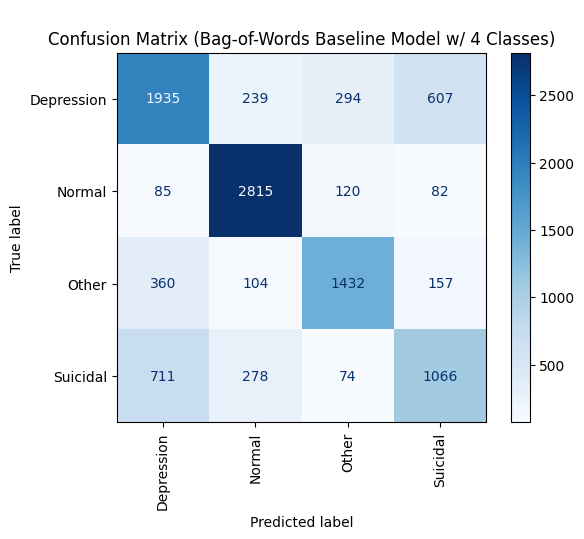

In [ ]:
# define path to the saved model
file_name = 'models/baseline_model_4.keras'
file_path = f"{folder_path}/{file_name}"

# split into training, validation, and test sets for 4 Class Grouping
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
  X_4,
  y_4,
  val_size = 0.2,
  test_size = 0.2,
  random_state = 42
)

if os.path.exists(file_path):  # load the baseline model if the file exists
  # load baseline model
  baseline_model_4 = load_model(file_path)

else:  # train a new baseline model if the model's file does not exist
  # clear session and set random seed
  shutil.rmtree('./untitled_project', ignore_errors=True)
  tf.keras.backend.clear_session()
  tf.random.set_seed(42)

  # define the TextVectorization layer
  vocab_size = 10000  # define vocab_size
  vectorize_layer = tf.keras.layers.TextVectorization(
      max_tokens = vocab_size,
      output_mode = 'binary',
  )
  vectorize_layer.adapt(X_train)  # adapt the layer to the training data

  # define max number of epochs for tuning
  max_epoch_val = 10

  # define early stopping
  stop_early = tf.keras.callbacks.EarlyStopping(
      monitor = 'val_accuracy',
      patience = 3
  )

  # define tuner for hyperparameter tuning
  tuner = kt.Hyperband(
      lambda hp: build_bow_model_tuner(hp, num_of_classes = 4),
      objective = 'val_accuracy',
      max_epochs = max_epoch_val
  )

  # perform hyperparameter tuning
  tuner.search(
      x = X_train,
      y = y_train,
      epochs = max_epoch_val,
      validation_data = (X_val, y_val),
      callbacks = [stop_early],
      verbose = 1
  )

  # get best hyperparameters
  best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

  # best learning rate
  print("Best Learning Rate:", best_hps.get('learning_rate'))

  # build and train model with best hyperparameters to find best epoch
  tuned_model = tuner.hypermodel.build(best_hps)
  history = tuned_model.fit(
      x = X_train,
      y = y_train,
      epochs = max_epoch_val,
      validation_data = (X_val, y_val),
      callbacks = [stop_early],
      verbose = 1
  )

  # get best epoch
  val_accuracy_per_epoch = history.history['val_accuracy']
  best_epoch = val_accuracy_per_epoch.index(max(val_accuracy_per_epoch)) + 1
  print("Best epoch: %d" % (best_epoch,))

  # train with best hyperparameters and best epoch to get final baseline model
  baseline_model_4 = tuner.hypermodel.build(best_hps)
  history = baseline_model_4.fit(
      x = X_train,
      y = y_train,
      epochs = best_epoch,
      validation_data = (X_val, y_val),
      verbose = 1
  )

  # get final accuracies
  training_accuracy = history.history['accuracy'][-1]
  validation_accuracy = history.history['val_accuracy'][-1]
  print('Training Accuracy: %.4f' % training_accuracy)
  print('Validation Accuracy: %.4f' % validation_accuracy)

  # save the baseline model
  baseline_model_4.save(file_path)

# get test accuracy, classification report, and confusion matrix
evaluate_model(
    model = baseline_model_4,
    model_name = "Bag-of-Words Baseline Model w/ 4 Classes",
    X_test = X_test,
    y_test = y_test,
    encoder = l_encoder_4
)

### Bag-of-Words (3 Classes)

Trial 3 Complete [00h 00m 44s]
val_accuracy: 0.505936861038208

Best val_accuracy So Far: 0.8374360203742981
Total elapsed time: 00h 02m 13s
Best Learning Rate: 0.01
Epoch 1/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.7746 - loss: 1598476189213655040.0000 - val_accuracy: 0.8372 - val_loss: 4191247340494913536.0000
Epoch 2/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8546 - loss: 1813994761908912128.0000 - val_accuracy: 0.8265 - val_loss: 9157747135595151360.0000
Epoch 3/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8520 - loss: 1752011855477342208.0000 - val_accuracy: 0.8206 - val_loss: 11887434834886262784.0000
Epoch 4/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8633 - loss: 2076504674868920320.0000 - val_accuracy: 0.8361 - val_loss: 3071100903122534400.0000
Best epoch: 1
972/972 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.7738 - loss: 1598709972873510912.0000 - val_accuracy: 0.8374 - val_loss: 4189712697140445184.0000


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 10000)               │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │          30,003 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,011 (351.61 KB)

 Trainable params: 30,003 (117.20 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 60,008 (234.41 KB)

Test Accuracy: 0.8344
324/324 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step

Classification Report (Bag-of-Words Baseline Model w/ 3 Classes):
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      5204
           1       0.81      0.93      0.87      3102
           2       0.79      0.65      0.72      2053

    accuracy                           0.83     10359
   macro avg       0.82      0.81      0.81     10359
weighted avg       0.83      0.83      0.83     10359



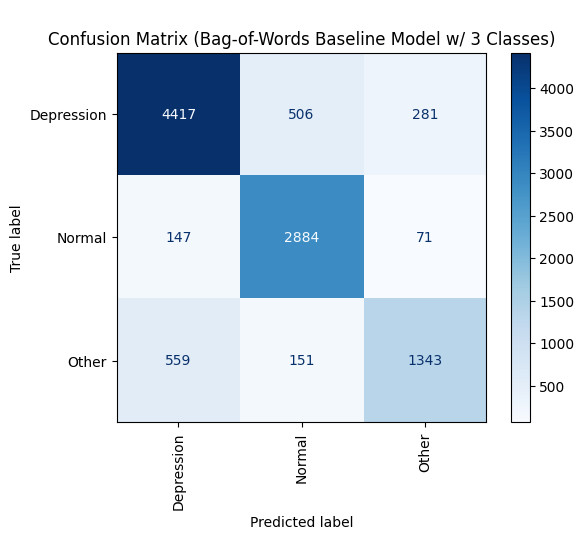

In [ ]:
# define path to the saved model
file_name = 'models/baseline_model_3.keras'
file_path = f"{folder_path}/{file_name}"

# split into training, validation, and test sets using the 3 Class Grouping
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
  X_3,
  y_3,
  val_size = 0.2,
  test_size = 0.2,
  random_state = 42
)

if os.path.exists(file_path):  # load the baseline model if the file exists
  # load baseline model
  baseline_model_3 = load_model(file_path)

else:  # train a new baseline model if the model's file does not exist
  # clear session and set random seed
  shutil.rmtree('./untitled_project', ignore_errors=True)
  tf.keras.backend.clear_session()
  tf.random.set_seed(42)

  # define the TextVectorization layer
  vocab_size = 10000  # define vocab_size
  vectorize_layer = tf.keras.layers.TextVectorization(
      max_tokens = vocab_size,
      output_mode = 'binary',
  )
  vectorize_layer.adapt(X_train)  # adapt the layer to the training data

  # define max number of epochs for tuning
  max_epoch_val = 10

  # define early stopping
  stop_early = tf.keras.callbacks.EarlyStopping(
      monitor = 'val_accuracy',
      patience = 3
  )

  # define tuner for hyperparameter tuning
  tuner = kt.Hyperband(
      lambda hp: build_bow_model_tuner(hp, num_of_classes = 3),
      objective = 'val_accuracy',
      max_epochs = max_epoch_val
  )

  # perform hyperparameter tuning
  tuner.search(
      x = X_train,
      y = y_train,
      epochs = max_epoch_val,
      validation_data = (X_val, y_val),
      callbacks = [stop_early],
      verbose = 1
  )

  # get best hyperparameters
  best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

  # best learning rate
  print("Best Learning Rate:", best_hps.get('learning_rate'))

  # build and train model with best hyperparameters to find best epoch
  tuned_model = tuner.hypermodel.build(best_hps)
  history = tuned_model.fit(
      x = X_train,
      y = y_train,
      epochs = max_epoch_val,
      validation_data = (X_val, y_val),
      callbacks = [stop_early],
      verbose = 1
  )

  # get best epoch
  val_accuracy_per_epoch = history.history['val_accuracy']
  best_epoch = val_accuracy_per_epoch.index(max(val_accuracy_per_epoch)) + 1
  print("Best epoch: %d" % (best_epoch,))

  # train with best hyperparameters and best epoch to get final baseline model
  baseline_model_3 = tuner.hypermodel.build(best_hps)
  history = baseline_model_3.fit(
      x = X_train,
      y = y_train,
      epochs = best_epoch,
      validation_data = (X_val, y_val),
      verbose = 1
  )

  # get final accuracies
  training_accuracy = history.history['accuracy'][-1]
  validation_accuracy = history.history['val_accuracy'][-1]
  print('Training Accuracy: %.4f' % training_accuracy)
  print('Validation Accuracy: %.4f' % validation_accuracy)

  # save the baseline model
  baseline_model_3.save(file_path)

# get test accuracy, classification report, and confusion matrix
evaluate_model(
    model = baseline_model_3,
    model_name = "Bag-of-Words Baseline Model w/ 3 Classes",
    X_test = X_test,
    y_test = y_test,
    encoder = l_encoder_3
)

---

# Step 10: Bag-of-Embeddings Model

### Model Architecture and Tuner

In [ ]:
# define bag-of-embeddings model architecture with hyperparameter tuning support
def build_boe_model_tuner(hp, num_of_classes):
  # define hyperparameters to tune
  hp_embedding_dim = hp.Choice('embedding_dim', values=[128, 200, 300])
  hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])

  # define vocab_size
  vocab_size = 10000

  # initialize the Sequential model
  model = tf.keras.Sequential()

  # add the text vectorization layer
  model.add(vectorize_layer)

  # add embedding layer
  model.add(tf.keras.layers.Embedding(
      input_dim = vocab_size,
      output_dim = hp_embedding_dim,
      input_length = None
  ))

  # Add pooling layer
  model.add(tf.keras.layers.GlobalAveragePooling1D())

  # add Dense layer
  model.add(tf.keras.layers.Dense(
      units = num_of_classes,
      activation = 'softmax'
  ))

  # configure the model
  model.compile(
        loss = 'sparse_categorical_crossentropy',
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        metrics = ['accuracy']
    )

  return model

### Bag-of-Embeddings (4 Classes)

Trial 9 Complete [00h 00m 09s]
val_accuracy: 0.69524085521698

Best val_accuracy So Far: 0.7110725045204163
Total elapsed time: 00h 01m 20s
Best Learning Rate: 0.01
Best Embedding Dimension: 300
Epoch 1/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5349 - loss: 1.0745 - val_accuracy: 0.6111 - val_loss: 0.9643
Epoch 2/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6877 - loss: 0.7733 - val_accuracy: 0.6797 - val_loss: 0.8135
Epoch 3/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7301 - loss: 0.6780 - val_accuracy: 0.6867 - val_loss: 0.8577
Epoch 4/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7555 - loss: 0.6255 - val_accuracy: 0.7217 - val_loss: 0.7442
Epoch 5/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7833 - loss: 0.5772 - val_accuracy: 0.7197 - val_loss: 0.8055
Epoch 6/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7995 - loss: 0.5421 - val_accuracy: 0.6931 - val_loss: 0.9223
Epoch 7/10
972/972 ━━━━━━━━━━━━━━━━━━

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 150)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 150, 300)            │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 300)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │           1,204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,003,614 (34.35 MB)

 Trainable params: 3,001,204 (11.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,002,410 (22.90 MB)

Test Accuracy: 0.7142
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report (Bag-of-Embeddings Model w/ 4 Classes):
              precision    recall  f1-score   support

           0       0.74      0.49      0.59      3075
           1       0.83      0.94      0.88      3102
           2       0.62      0.83      0.71      2053
           3       0.62      0.59      0.60      2129

    accuracy                           0.71     10359
   macro avg       0.70      0.71      0.70     10359
weighted avg       0.72      0.71      0.70     10359



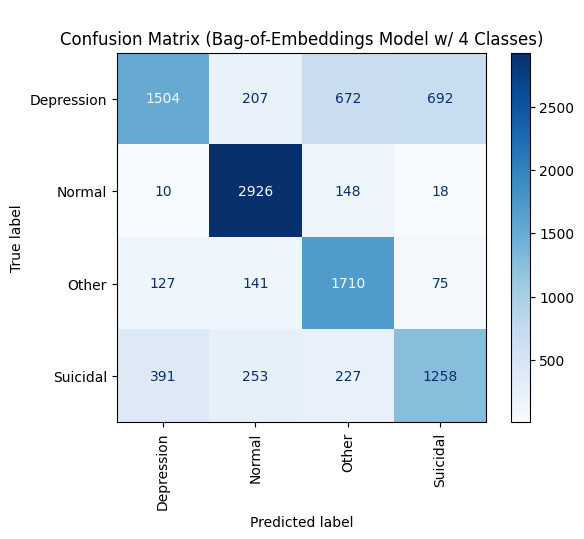

In [ ]:
# define path to the saved model
file_name = 'models/bagofembeddings_model_4.keras'
file_path = f"{folder_path}/{file_name}"

# use 4 Class Grouping
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
  X_4,
  y_4,
  val_size = 0.2,
  test_size = 0.2,
  random_state = 42
)

if os.path.exists(file_path):  # load the boe model if the file exists
  # load boe model
  bagofembeddings_model_4 = load_model(file_path)

else:  # train a new boe model if the model's file does not exist
  # clear session and set random seed
  shutil.rmtree('./untitled_project', ignore_errors=True)
  tf.keras.backend.clear_session()
  tf.random.set_seed(42)

  # define the TextVectorization layer
  vocab_size = 10000  # define vocab_size
  vectorize_layer = tf.keras.layers.TextVectorization(
      max_tokens = vocab_size,
      output_mode = 'int',
      output_sequence_length = 150
  )
  vectorize_layer.adapt(X_train)  # adapt the layer to the training data

  # define max number of epochs for tuning
  max_epoch_val = 10

  # define early stopping
  stop_early = tf.keras.callbacks.EarlyStopping(
      monitor = 'val_accuracy',
      patience = 3
  )

  # define tuner for hyperparameter tuning
  tuner = kt.Hyperband(
      lambda hp: build_boe_model_tuner(hp, num_of_classes = 4),
      objective = 'val_accuracy',
      max_epochs = max_epoch_val
  )

  # perform hyperparemter search
  tuner.search(
      x = X_train,
      y = y_train,
      epochs = max_epoch_val,
      validation_data = (X_val, y_val),
      callbacks = [stop_early],
      verbose = 1
  )

  # get best hyperparameters
  best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

  # best learning rate and embedding dimensions
  print(f"Best Learning Rate: {best_hps.get('learning_rate')}")
  print(f"Best Embedding Dimension: {best_hps.get('embedding_dim')}")

  # build and train model with optimal hyperparameters to find best epoch
  tuned_model = tuner.hypermodel.build(best_hps)
  history = tuned_model.fit(
      x = X_train,
      y = y_train,
      epochs = max_epoch_val,
      validation_data = (X_val, y_val),
      callbacks = [stop_early],
      verbose = 1
  )

  # get best epoch
  val_accuracy_per_epoch = history.history['val_accuracy']
  best_epoch = val_accuracy_per_epoch.index(max(val_accuracy_per_epoch)) + 1
  print("Best epoch: %d" % (best_epoch,))

  # tune batch size with the best hyperparameters and best epoch
  # define batch sizes to try
  batch_sizes = [16, 32]
  best_batch_size = None
  best_val_accuracy = 0

  # go through each batch size
  for batch_size in batch_sizes:
      print(f"Testing batch size: {batch_size}")
      model = tuner.hypermodel.build(best_hps)
      history = model.fit(
          x=X_train,
          y=y_train,
          epochs=best_epoch,
          batch_size=batch_size,
          validation_data=(X_val, y_val),
          verbose=1
      )
      val_accuracy = history.history['val_accuracy'][-1]
      print(f"Validation Accuracy with batch size {batch_size}: {val_accuracy:.4f}")

      if val_accuracy > best_val_accuracy:
          best_val_accuracy = val_accuracy
          best_batch_size = batch_size

  # get best batch size
  print(f"Best Batch Size: {best_batch_size}")

  # train with best hyperparameters to get final boe model
  bagofembeddings_model_4 = tuner.hypermodel.build(best_hps)
  history = bagofembeddings_model_4.fit(
      x = X_train,
      y = y_train,
      epochs = best_epoch,
      batch_size = best_batch_size,
      validation_data = (X_val, y_val),
      verbose = 1
  )

  # get final accuracies with all tuned hyperparameters
  training_accuracy = history.history['accuracy'][-1]
  validation_accuracy = history.history['val_accuracy'][-1]
  print('Training Accuracy: %.4f' % training_accuracy)
  print('Validation Accuracy: %.4f' % validation_accuracy)

  # save the baseline model
  bagofembeddings_model_4.save(file_path)

# get test accuracy, classification report, and confusion matrix
evaluate_model(
    model = bagofembeddings_model_4,
    model_name = "Bag-of-Embeddings Model w/ 4 Classes",
    X_test = X_test,
    y_test = y_test,
    encoder = l_encoder_4
)

### Bag-of-Embeddings (3 Classes)

Trial 9 Complete [00h 00m 09s]
val_accuracy: 0.6654117107391357

Best val_accuracy So Far: 0.8256588578224182
Total elapsed time: 00h 01m 21s
Best Learning Rate: 0.001
Best Embedding Dimension: 128
Epoch 1/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6328 - loss: 0.8251 - val_accuracy: 0.7910 - val_loss: 0.5412
Epoch 2/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7878 - loss: 0.5357 - val_accuracy: 0.8261 - val_loss: 0.4698
Epoch 3/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8231 - loss: 0.4630 - val_accuracy: 0.8342 - val_loss: 0.4315
Epoch 4/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8442 - loss: 0.4164 - val_accuracy: 0.8378 - val_loss: 0.4195
Epoch 5/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8602 - loss: 0.3824 - val_accuracy: 0.8357 - val_loss: 0.4259
Epoch 6/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8716 - loss: 0.3555 - val_accuracy: 0.8369 - val_loss: 0.4360
Epoch 7/10
972/972 ━━━━━━━━━━━━━━━

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 150)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 150, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,841,163 (14.65 MB)

 Trainable params: 1,280,387 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,776 (9.77 MB)

Test Accuracy: 0.8403
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report (Bag-of-Embeddings Model w/ 3 Classes):
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      5204
           1       0.82      0.96      0.88      3102
           2       0.84      0.54      0.66      2053

    accuracy                           0.84     10359
   macro avg       0.84      0.80      0.80     10359
weighted avg       0.84      0.84      0.83     10359



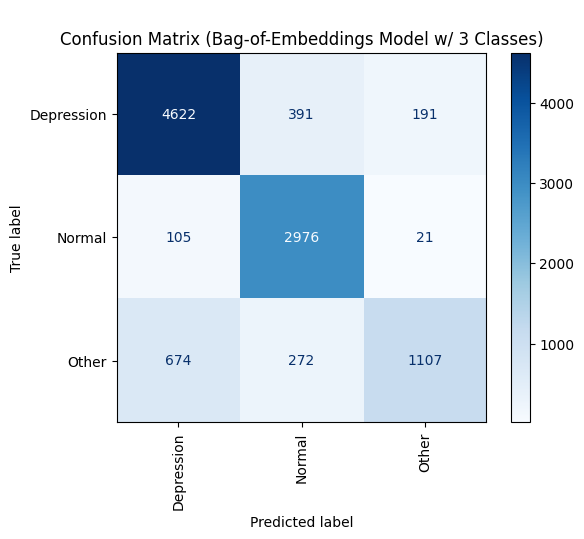

In [ ]:
# define path to the saved model
file_name = 'models/bagofembeddings_model_3.keras'
file_path = f"{folder_path}/{file_name}"

# use 3 Class Grouping
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
  X_3,
  y_3,
  val_size = 0.2,
  test_size = 0.2,
  random_state = 42
)

if os.path.exists(file_path):  # load the boe model if the file exists
  # load boe model
  bagofembeddings_model_3 = load_model(file_path)

else:  # train a new boe model if the model's file does not exist
  # clear session and set random seed
  shutil.rmtree('./untitled_project', ignore_errors=True)
  tf.keras.backend.clear_session()
  tf.random.set_seed(42)

  # define the TextVectorization layer
  vocab_size = 10000  # define vocab_size
  vectorize_layer = tf.keras.layers.TextVectorization(
      max_tokens = vocab_size,
      output_mode = 'int',
      output_sequence_length = 150
  )
  vectorize_layer.adapt(X_train)  # adapt the layer to the training data

  # define max number of epochs for tuning
  max_epoch_val = 10

  # define early stopping
  stop_early = tf.keras.callbacks.EarlyStopping(
      monitor = 'val_accuracy',
      patience = 3
  )

  # define tuner for hyperparameter tuning
  tuner = kt.Hyperband(
      lambda hp: build_boe_model_tuner(hp, num_of_classes = 3),
      objective = 'val_accuracy',
      max_epochs = max_epoch_val
  )

  # perform hyperparemter search
  tuner.search(
      x = X_train,
      y = y_train,
      epochs = max_epoch_val,
      validation_data = (X_val, y_val),
      callbacks = [stop_early],
      verbose = 1
  )

  # get best hyperparameters
  best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

  # best learning rate and embedding dimensions
  print(f"Best Learning Rate: {best_hps.get('learning_rate')}")
  print(f"Best Embedding Dimension: {best_hps.get('embedding_dim')}")

  # build and train model with optimal hyperparameters to find best epoch
  tuned_model = tuner.hypermodel.build(best_hps)
  history = tuned_model.fit(
      x = X_train,
      y = y_train,
      epochs = max_epoch_val,
      validation_data = (X_val, y_val),
      callbacks = [stop_early],
      verbose = 1
  )

  # get best epoch
  val_accuracy_per_epoch = history.history['val_accuracy']
  best_epoch = val_accuracy_per_epoch.index(max(val_accuracy_per_epoch)) + 1
  print("Best epoch: %d" % (best_epoch,))

  # tune batch size with the best hyperparameters and best epoch
  # define batch sizes to try
  batch_sizes = [16, 32]
  best_batch_size = None
  best_val_accuracy = 0

  # go through each batch size
  for batch_size in batch_sizes:
      print(f"Testing batch size: {batch_size}")
      model = tuner.hypermodel.build(best_hps)
      history = model.fit(
          x=X_train,
          y=y_train,
          epochs=best_epoch,
          batch_size=batch_size,
          validation_data=(X_val, y_val),
          verbose=1
      )
      val_accuracy = history.history['val_accuracy'][-1]
      print(f"Validation Accuracy with batch size {batch_size}: {val_accuracy:.4f}")

      if val_accuracy > best_val_accuracy:
          best_val_accuracy = val_accuracy
          best_batch_size = batch_size

  # get best batch size
  print(f"Best Batch Size: {best_batch_size}")

  # train with best hyperparameters to get final boe model
  bagofembeddings_model_3 = tuner.hypermodel.build(best_hps)
  history = bagofembeddings_model_3.fit(
      x = X_train,
      y = y_train,
      epochs = best_epoch,
      batch_size = best_batch_size,
      validation_data = (X_val, y_val),
      verbose = 1
  )

  # get final accuracies with all tuned hyperparameters
  training_accuracy = history.history['accuracy'][-1]
  validation_accuracy = history.history['val_accuracy'][-1]
  print('Training Accuracy: %.4f' % training_accuracy)
  print('Validation Accuracy: %.4f' % validation_accuracy)

  # save the baseline model
  bagofembeddings_model_3.save(file_path)

# get test accuracy, classification report, and confusion matrix
evaluate_model(
    model = bagofembeddings_model_3,
    model_name = "Bag-of-Embeddings Model w/ 3 Classes",
    X_test = X_test,
    y_test = y_test,
    encoder = l_encoder_3
)